## 1. Enviar dados para o HDFS

In [ ]:
#Criar um pasta no namenode e HDFS chamada projeto_final_covid
#docker cp "D:\Curso_SemantixEngDados\Projeto\dados" namenode:/projeto_final_covid
#hdfs dfs -put file:///projeto_final_covid/dados /user/caio/projeto_final_covid

## 2. Otimizar todos os dados do hdfs para uma tabela Hive particionada por município

In [ ]:
'''
CREATE DATABASE caio_projeto;
USE caio_projeto;

DROP TABLE IF EXISTS dados_covid_origem;
DROP TABLE IF EXISTS dados_covid;

CREATE EXTERNAL TABLE dados_covid_origem(
     regiao STRING,
     estado STRING,
     municipio STRING,
     cod_Uf INT,
     cod_mun INT,
     cod_regiao_saude INT,
     nome_regiao_saude STRING,
     data_referente DATE,
     semana_epi INT,
     populacao BIGINT,
     casos_acumulados BIGINT,
     casos_novos BIGINT,
     obitos_acumulados BIGINT,
     obitos_novos BIGINT,
     casos_recuperados_novos BIGINT,
     casos_acompanhamento_novos BIGINT,
     fl_interior_metropolitana TINYINT
 )
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ';'
LINES TERMINATED BY '\n'
STORED AS TEXTFILE
LOCATION '/user/caio/projeto_final_covid/dados'
tblproperties('skip.header.line.count'='1', 'store.charset'='ISO-8859-1', 'retrieve.charset'='ISO-8859-1');

'''




'''
CREATE TABLE dados_covid(
     regiao STRING,
     estado STRING,
     cod_Uf INT,
     cod_mun INT,
     cod_regiao_saude INT,
     nome_regiao_saude STRING,
     data_referente DATE,
     semana_epi INT,
     populacao BIGINT,
     casos_acumulados BIGINT,
     casos_novos BIGINT,
     obitos_acumulados BIGINT,
     obitos_novos BIGINT,
     casos_recuperados_novos BIGINT,
     casos_acompanhamento_novos BIGINT,
     fl_interior_metropolitana TINYINT
 )
PARTITIONED BY (municipio string)
STORED AS TEXTFILE;


set hive.exec.dynamic.partition=true;
set hive.exec.dynamic.partition.mode=nonstrict;

INSERT INTO TABLE dados_covid partition(municipio)
SELECT CASE WHEN regiao = '' THEN 'NA' ELSE regiao END AS regiao,
    CASE WHEN estado = '' THEN 'NA' ELSE estado END AS estado,
    CASE WHEN municipio = '' THEN 'NA' ELSE municipio END AS municipio, 
    CAST(coalesce(cod_Uf,0) AS INT) AS cod_Uf,
    CAST(coalesce(cod_mun,0) AS INT) AS cod_mun,
    CAST(coalesce(cod_regiao_saude,0) AS INT) AS cod_regiao_saude,
    CAST(coalesce(nome_regiao_saude, 'NA') AS STRING) AS nome_regiao_saude,
    CAST(coalesce(data_referente, 'NA') AS DATE) AS data_referente,
    CAST(coalesce(semana_epi, 0) AS INT) AS semana_epi,
    CAST(coalesce(populacao,0) AS BIGINT) AS populacao,
    CAST(coalesce(casos_acumulados, 0) AS BIGINT) AS casos_acumulados,
    CAST(coalesce(casos_novos, 0) AS BIGINT) AS casos_novos,
    CAST(coalesce(obitos_acumulados,0) AS BIGINT) AS obitos_acumulados,
    CAST(coalesce(obitos_novos,0) AS BIGINT) AS obitos_novos,
    CAST(coalesce(casos_recuperados_novos,0) AS BIGINT) AS casos_recuperados_novos,
    CAST(coalesce(casos_acompanhamento_novos,0) AS BIGINT) AS casos_acompanhamento_novos,
    CAST(coalesce(fl_interior_metropolitana,0) AS TINYINT) AS fl_interior_metropolitana
FROM dados_covid_origem;
'''

## 3. Criar as 3 vizualizações pelo Spark com os dados enviados para o HDFS 

In [1]:
from pyspark.sql.functions import *
from pyspark.sql.types import StructType

In [2]:
#Carrega dados
schema_dados = StructType().add("regiao", "string")\
                           .add("estado", "string")\
                           .add("municipio", "string")\
                           .add("cod_uf", "long")\
                           .add("cod_mun", "long")\
                           .add("cod_regiao_saude", "long")\
                           .add("nome_regiao_saude", "string")\
                           .add("data_referente", "date")\
                           .add("semana_epi", "long")\
                           .add("populacao", "long")\
                           .add("casos_acumulados", "long")\
                           .add("casos_novos", "long")\
                           .add("obitos_acumulados", "long")\
                           .add("obitos_novos", "long")\
                           .add("casos_recuperados_novos", "long")\
                           .add("casos_acompanhamento_novos", "long")\
                           .add("fl_interior_metropolitana", "long")
                           
dados = spark.read.csv('/user/caio/projeto_final_covid/dados/*.csv', header=True, sep=';', schema=schema_dados)

In [3]:
ultima_data = dados.agg({"data_referente": "max"}).collect()[0][0]

## Primeira Visualização

In [4]:
#Primeira visulizaçao casos recuperados
df_recuperados = dados.filter(f"data_referente == '{ultima_data}' and regiao = 'Brasil' ")\
                      .select(sum("casos_recuperados_novos").alias("casos_recuperados"),\
                              sum("casos_acompanhamento_novos").alias("em_acompanhamento"))
df_recuperados.show()

+-----------------+-----------------+
|casos_recuperados|em_acompanhamento|
+-----------------+-----------------+
|         17262646|          1065477|
+-----------------+-----------------+



#### Salvar os dados no Hive

In [5]:
df_recuperados.createOrReplaceTempView("recuperados_temp")
spark.sql("create table IF NOT EXISTS caio_projeto.recuperados as select * from recuperados_temp");

#### Resultado:

![resultado_hive.png](https://cdn.discordapp.com/attachments/936382489361023027/967831687264366652/unknown.png)
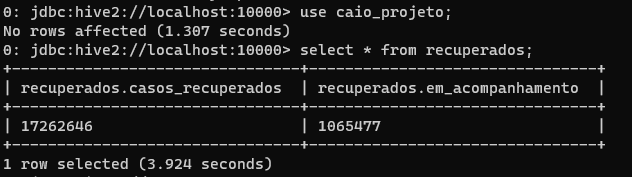

## Segunda Visualização

In [6]:
#Segunda visualização casos confirmados
df_casos = dados.filter(f"data_referente == '{ultima_data}' and regiao = 'Brasil' ")\
                .groupBy("populacao")\
                .agg(sum("casos_acumulados").alias("casos_acumulados"),\
                        sum("casos_novos").alias("casos_novos")) 
df_casos = df_casos.withColumn("incidencia", format_number(col("casos_acumulados") / col("populacao"), 6) * 100000)\
                   .select(col("casos_acumulados"), col("casos_novos"), col("incidencia"))
df_casos.show()

+----------------+-----------+----------+
|casos_acumulados|casos_novos|incidencia|
+----------------+-----------+----------+
|        18855015|      62504|    8972.3|
+----------------+-----------+----------+



#### Salvar os dados como parquet

In [7]:
#Criar diretorio no HDFS /user/caio/projeto_final_covid/out
df_casos.write.parquet('/user/caio/projeto_final_covid/out/parquet', mode='overwrite')

#### Resultado:

![resultado_parquet.png](https://cdn.discordapp.com/attachments/936382489361023027/967832358336217180/unknown.png)
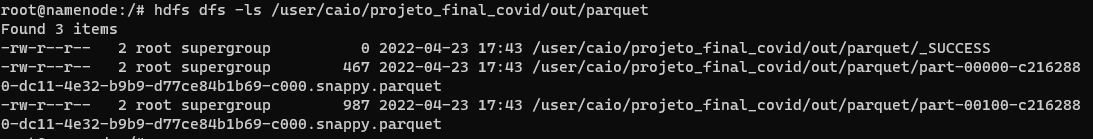

## Terceira Visualização

In [8]:
#Terceira visualização obitos confirmados
df_obitos = dados.filter(f"data_referente == '{ultima_data}' and regiao = 'Brasil' ")\
                 .groupBy("populacao")\
                 .agg(sum("obitos_acumulados").alias("obitos_acumulados"),\
                         sum("obitos_novos").alias("obitos_novos"),\
                         sum("casos_acumulados").alias("casos_acumulados"))
df_obitos = df_obitos.withColumn("letalidade", format_number(col("obitos_acumulados") / col("casos_acumulados"), 4) * 100) \
                     .withColumn("mortalidade", format_number(col("obitos_acumulados") / col("populacao"), 8) * 100000)\
                     .select( col("obitos_acumulados"), col("obitos_novos"),col("letalidade"), col("mortalidade"))
df_obitos.show()

+-----------------+------------+----------+-----------+
|obitos_acumulados|obitos_novos|letalidade|mortalidade|
+-----------------+------------+----------+-----------+
|           526892|        1780|      2.79|    250.725|
+-----------------+------------+----------+-----------+



#### Salvar os dados em um topico do Kafka

In [9]:
'''
Criar um topico: 
kafka-topics.sh --bootstrap-server kafka:9092 --topic topic-obitos --create --partitions 1 --replication-factor 1
'''

df_obitos.selectExpr("to_json(struct(*)) AS value") \
  .write \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "kafka:9092") \
  .option("topic", "topic-obitos") \
  .save()

#### Resultado:

![resultado_kafka.png](https://cdn.discordapp.com/attachments/936382489361023027/967828943493300274/unknown.png)
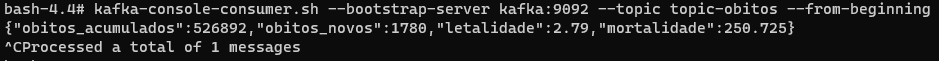

## 7. Criar a visualização pelo Spark com os dados enviados para o HDFS

In [10]:
df_sintese = dados.filter(f"data_referente == '{ultima_data}' and cod_mun is null ")\
                  .groupBy("regiao", "data_referente")\
                  .agg(sum("casos_acumulados").alias("Casos"),\
                       sum("obitos_acumulados").alias("Obitos"),\
                       sum("populacao").alias("populacao"))

df_sintese = df_sintese.withColumn("incidencia", regexp_replace(format_number(col("Casos") / col("populacao") * 100000,\
                                                                1), ',', ''))\
                       .withColumn("mortalidade", format_number(col("Obitos") / col("populacao") * 100000, 1))\
                       .select(col("regiao"), col("Casos"), col("Obitos"), col("incidencia"),\
                               col("mortalidade"), col("data_referente")).sort(asc("regiao"))

df_sintese.show()

+------------+--------+------+----------+-----------+--------------+
|      regiao|   Casos|Obitos|incidencia|mortalidade|data_referente|
+------------+--------+------+----------+-----------+--------------+
|      Brasil|18855015|526892|    8972.3|      250.7|    2021-07-06|
|Centro-Oeste| 1916619| 49207|   11760.5|      301.9|    2021-07-06|
|    Nordeste| 4455737|107824|    7807.3|      188.9|    2021-07-06|
|       Norte| 1732815| 43845|    9401.6|      237.9|    2021-07-06|
|     Sudeste| 7138803|245311|    8078.2|      277.6|    2021-07-06|
|         Sul| 3611041| 80705|   12046.4|      269.2|    2021-07-06|
+------------+--------+------+----------+-----------+--------------+



## Salvar a visualização do exercício 6 em um tópico no Elastic

In [11]:
#Salvar o arquivo no HDFS para a ingestão no elastic
df_obitos.write.csv('/user/caio/projeto_final_covid/out/elastic', header=True, sep=',', mode='overwrite')

In [ ]:
#Transferir os dados do HDFS para o namenode
#hdfs dfs -get /user/caio/projeto_final_covid/out/elastic/*.csv /projeto_final_covid/out

#Transferir do namenode para o local
#docker cp namenode:/projeto_final_covid/out "D:\Curso_SemantixEngDados\Projeto"

#### Em http://localhost:5601 acessar a aba Kibana, guia machine learning e clicar em Upload File:

![upload_file.png](https://cdn.discordapp.com/attachments/936382489361023027/967594988126994473/unknown.png)
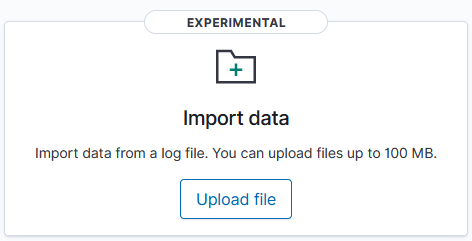

#### Selecionar o arquivo gerado pelo Spark:

![selecionar_arquivo.png](https://cdn.discordapp.com/attachments/936382489361023027/967591886606958632/unknown.png)
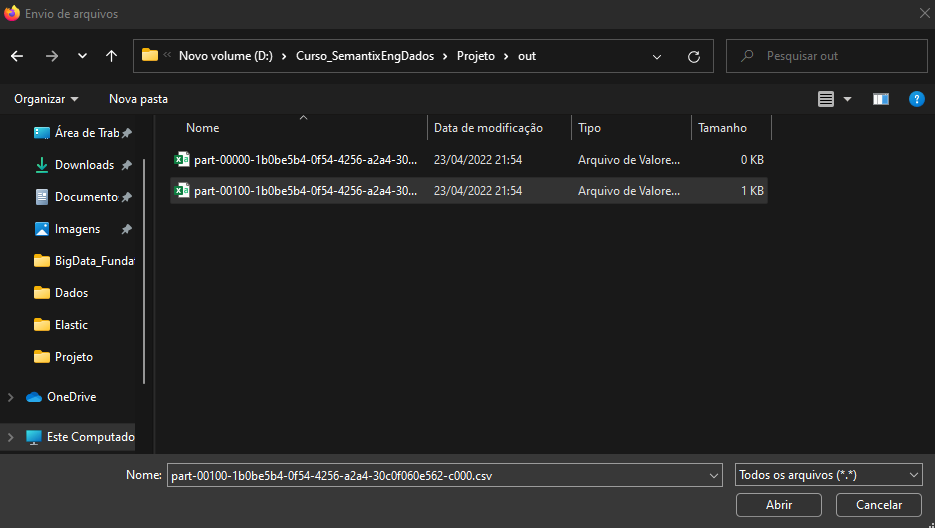

#### Criar um index chamado caio-projeto-final:

![criar_index.png](https://cdn.discordapp.com/attachments/936382489361023027/967594829850767400/unknown.png)
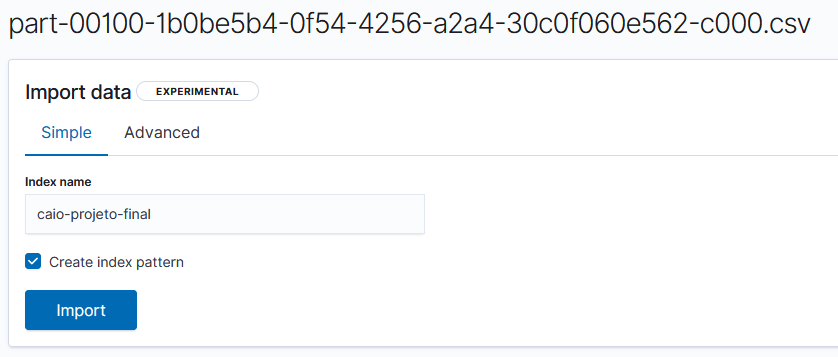

#### Verificar os dados importados:

![verificar_index.png](https://cdn.discordapp.com/attachments/936382489361023027/967594910565957652/unknown.png)
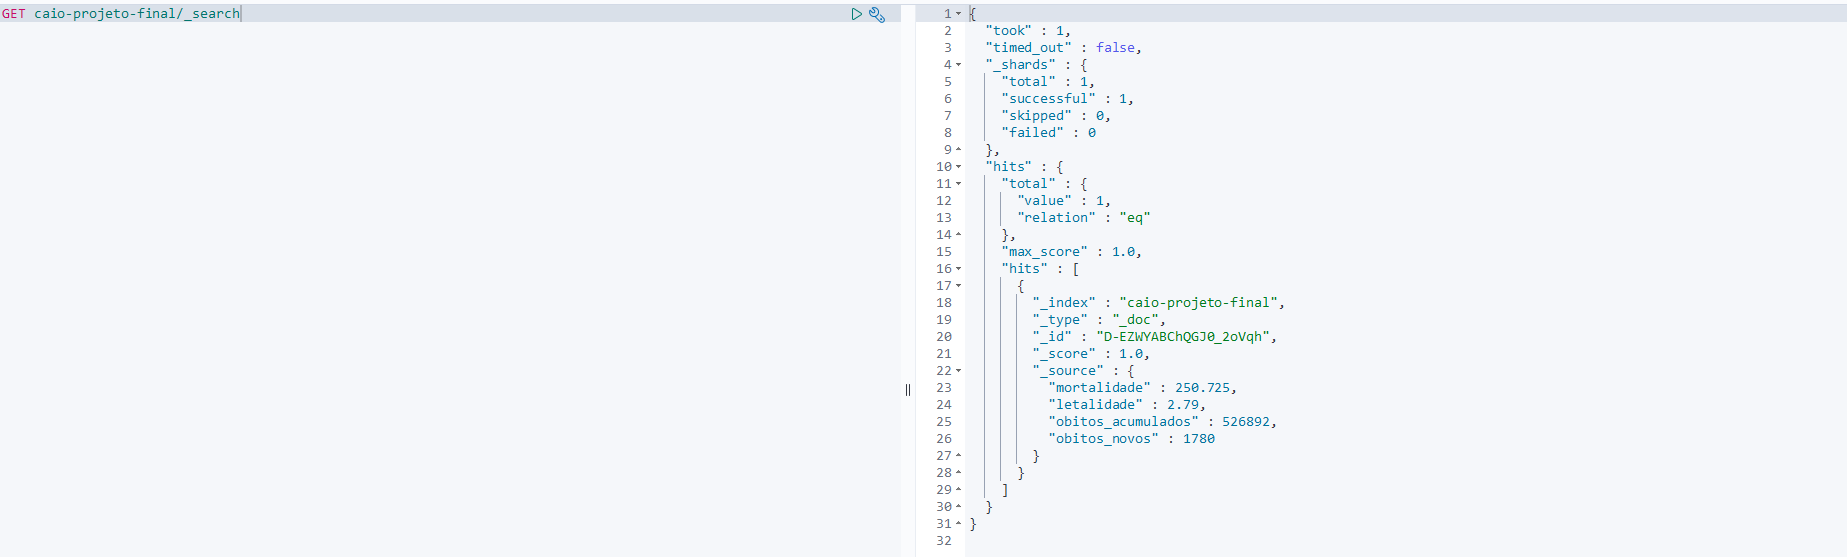

## Criar um dashboard no Elastic para visualização dos novos dados enviados

#### Acessar a aba Kibana, guia dashboard, clique em create new dashboard e selecione o dash:

![selecionar_dash.png](https://cdn.discordapp.com/attachments/936382489361023027/967603354513588264/unknown.png)
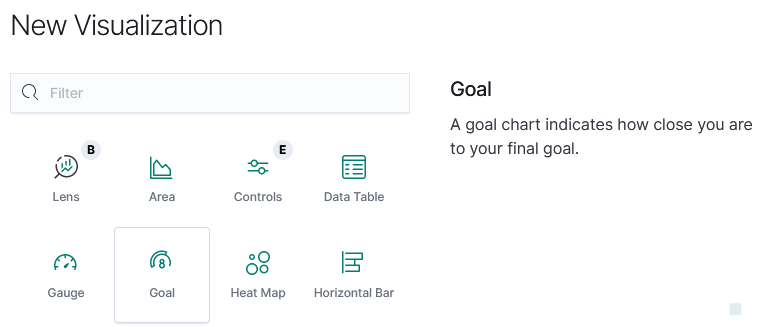

#### Selecione a metrica desejada:

![dash.png](https://cdn.discordapp.com/attachments/936382489361023027/967603485505884200/unknown.png)
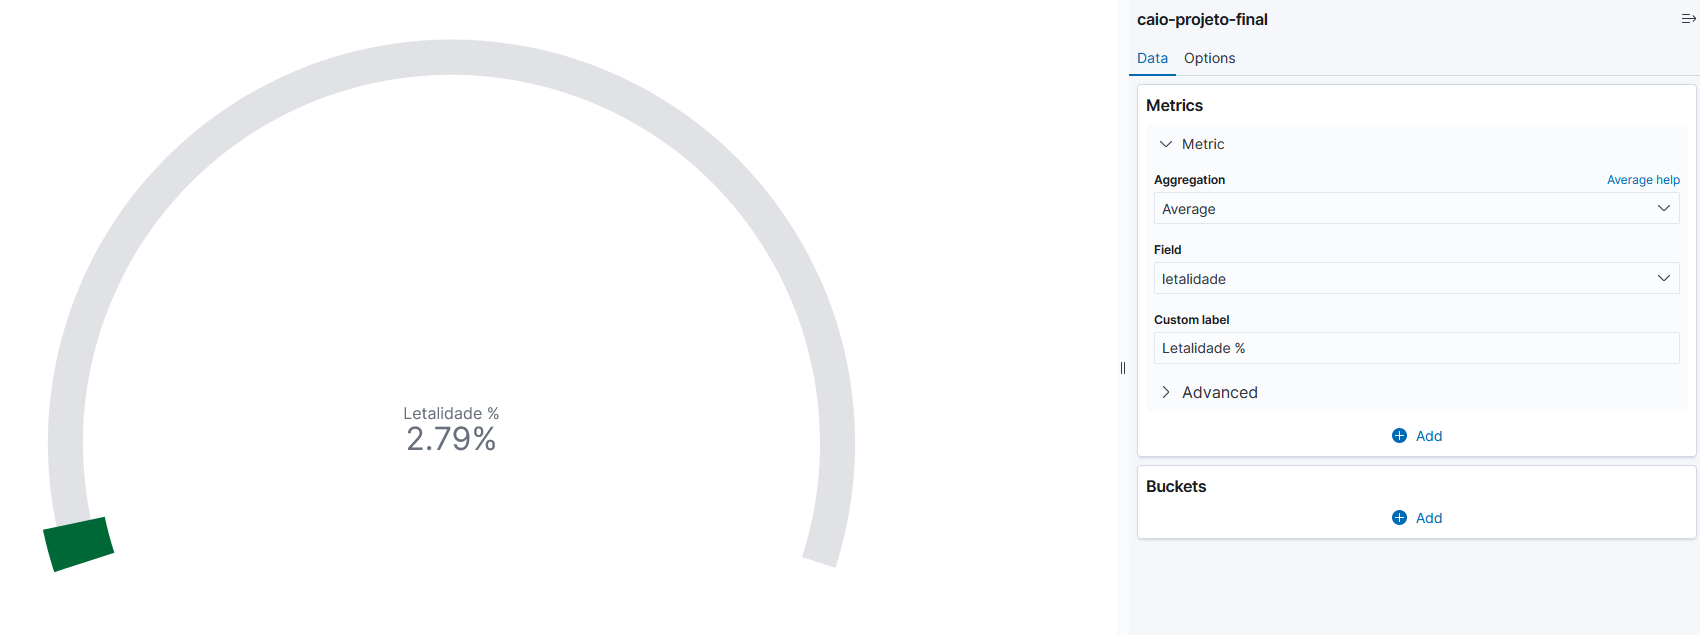

#### Na aba options altere o range e depois clique em save:

![options.png](https://cdn.discordapp.com/attachments/936382489361023027/967603581584801802/unknown.png)
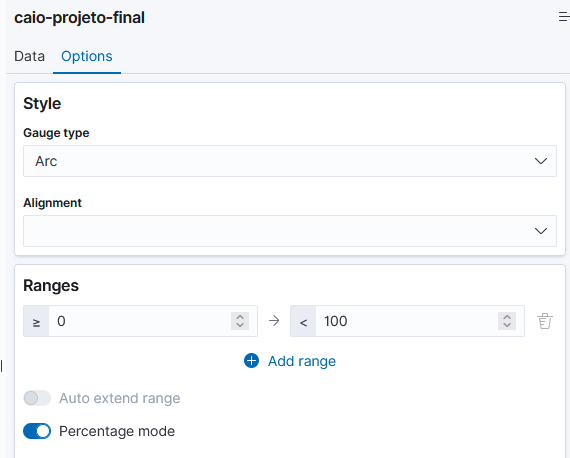

#### Para criar uma nova visualização, clique em create new dashboard:

![selecionar_dash_2.png](https://cdn.discordapp.com/attachments/936382489361023027/967610444174999552/unknown.png)
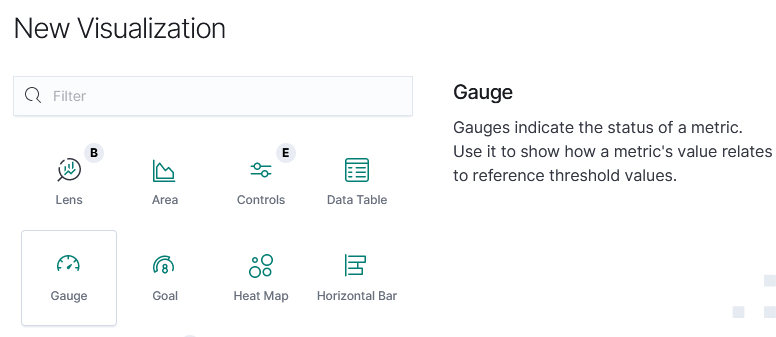

#### Selecione a metrica desejada:

![dash_2.png](https://cdn.discordapp.com/attachments/936382489361023027/967603946480877638/unknown.png)
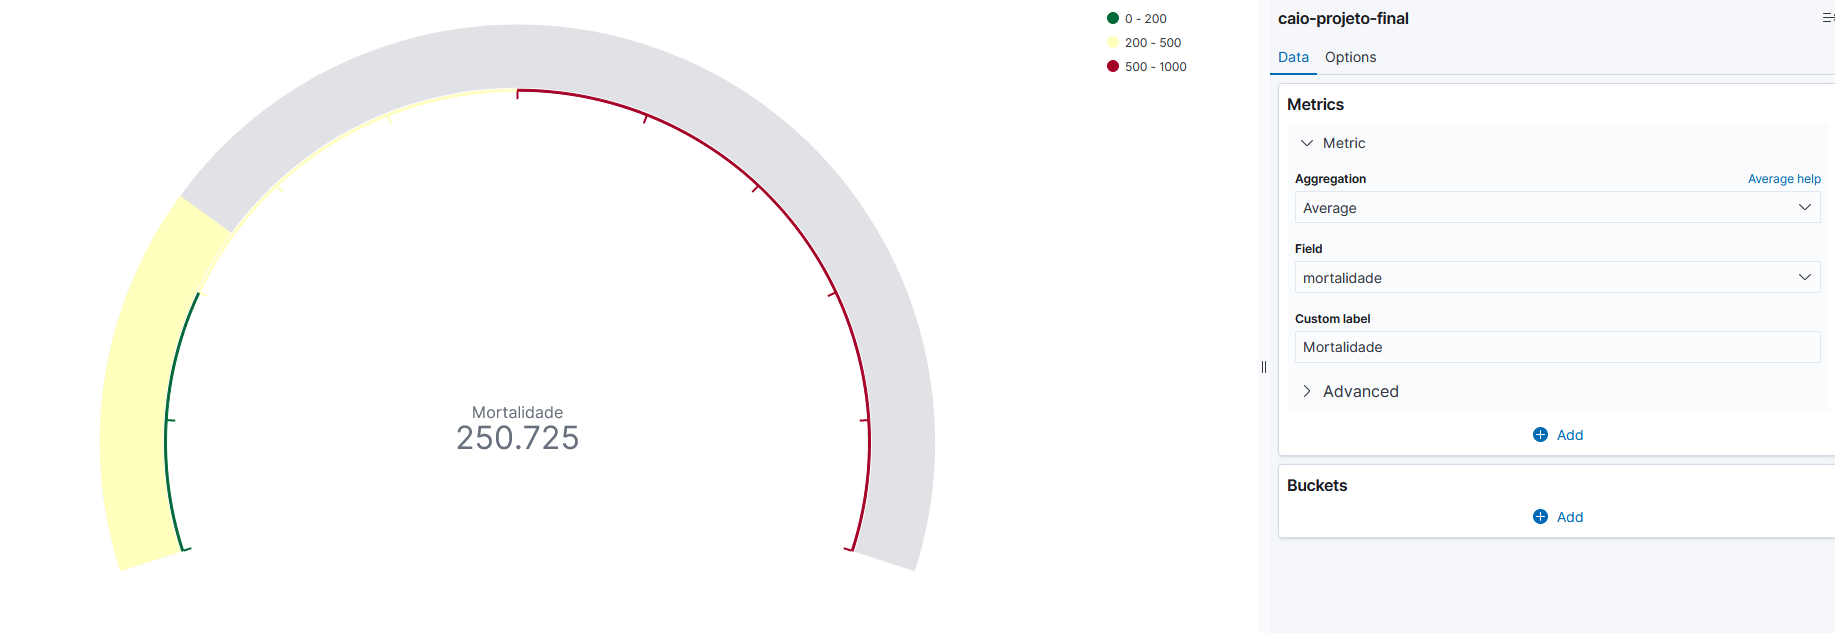

#### Na aba options altere os ranges e depois clique em save:

![options_2.png](https://cdn.discordapp.com/attachments/936382489361023027/967604004609720421/unknown.png)
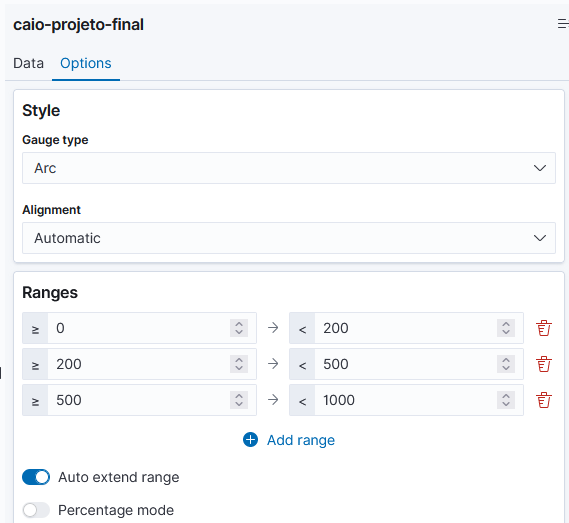

#### Para visualizar os dois dashboards criados clique na aba dashboard:

![Dashs.png](https://cdn.discordapp.com/attachments/936382489361023027/967826240968999022/unknown.png)
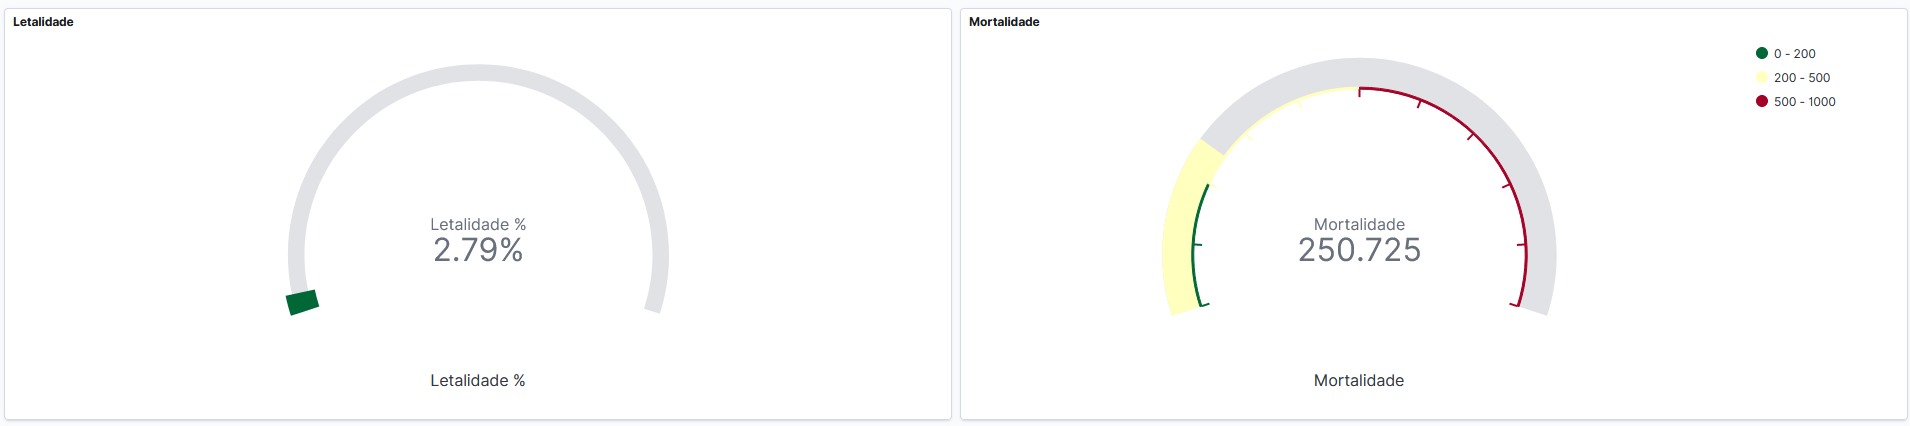